# Session 14_15: Preparing Dataset

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import torch
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.5.0+cu101 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [0]:
import os
import time
import numpy as np
import pandas as pd
import shutil
from tqdm import tqdm
import cv2

from PIL import Image
from google.colab.patches import cv2_imshow

import zipfile
from io import BytesIO

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# initialize dataset locations
ROOT_IMAGE_DIR = "/content/gdrive/My Drive/TSAI/EVA_Phase1/session14_15/s15_assignment_A/dataset1"

In [5]:
# switch to root working directory
cd /content/gdrive/My Drive/TSAI/EVA_Phase1/session14_15/s15_assignment_A/

/content/gdrive/My Drive/TSAI/EVA_Phase1/session14_15/s15_assignment_A


### Utility functions for dataset creation

In [0]:
def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]

'''
crop center part of the image
'''
def img_center_crop(img, size=(192,192)):
    h,w = img.shape[:2]
    x1 = w // 2 - size[1] // 2
    x2 = w // 2 + size[1] // 2
    
    y1 = h // 2 - size[0] // 2
    y2 = h // 2 + size[0] // 2
    
    return img[y1:y2, x1:x2]

'''
get mask for forground image: not used.. used power point tool to generate mask using alpha channel. kept for furture use
'''
def fg_get_mask(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    th, threshed = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

    roi, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #CHAIN_APPROX_SIMPLE

    mask = np.zeros(img.shape, img.dtype)

    cv2.fillPoly(mask, roi, (255,)*img.shape[2])

    return mask

'''
find the object outer structure and cut that portion
'''
def fg_cut(img):
    # crop image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    th, threshed = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

    cnts, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = sorted(cnts, key=cv2.contourArea)[-1]
    x,y,w,h = cv2.boundingRect(cnt)
    new_img = img[y:y+h, x:x+w]

    return new_img        

# input is 4 channel(png with alpha)..convert to 3 channels before using as fg images
def fg_convert_4c_to_3c(img):
    # If the image has an alpha channel, convert it to white
    # Otherwise we'll get weird pixels
    for y in range(img.shape[1]): # For each row ...
        for x in range(img.shape[0]): # Iterate through each column ...
            # Check if it's opaque
            if img[x, y][3] < 255:
                # Replace the pixel data with the colour white
                img[x, y] = (255, 255, 255, 255)
    return img

def fg_fourChannels(img):
    height, width, channels = img.shape
    if channels < 4:
        new_img = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
        return new_img
    return img

def fg_crop_and_resize(img, w, h):
    im_h, im_w, channels = img.shape
    res_aspect_ratio = w/h
    input_aspect_ratio = im_w/im_h

    if input_aspect_ratio > res_aspect_ratio:
        im_w_r = int(input_aspect_ratio*h)
        im_h_r = h
        img = cv2.resize(img, (im_w_r , im_h_r))
        x1 = int((im_w_r - w)/2)
        x2 = x1 + w
        img = img[:, x1:x2, :]
        
    if input_aspect_ratio < res_aspect_ratio:
        im_w_r = w
        im_h_r = int(w/input_aspect_ratio)
        img = cv2.resize(img, (im_w_r , im_h_r))
        y1 = int((im_h_r - h)/2)
        y2 = y1 + h
        img = img[y1:y2, :, :]
        
    if input_aspect_ratio == res_aspect_ratio:
        img = cv2.resize(img, (w, h))

    return img
    
def fg_resize_image(img, size=(28,28)):

    h, w, c = img.shape

    if h == w: 
        return cv2.resize(img, size, cv2.INTER_AREA)

    dif = h if h > w else w

    interpolation = cv2.INTER_AREA if dif > (size[0]+size[1])//2 else cv2.INTER_CUBIC

    x_pos = (dif - w)//2
    y_pos = (dif - h)//2

    if len(img.shape) == 2:
        mask = np.zeros((dif, dif), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
    else:
        mask = np.zeros((dif, dif, c), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]

    return cv2.resize(mask, size, interpolation)

'''
inp_dir: foreground imgages with transparent background. these image are create using power point or GIMP
         make sure that files names are in order with following format: img_093.jpg
fg_dir: final scaled foreground images with only object and transparent background
mask_dir: equivalent mask of images in fg_dir. file name shall be same for simplicity and tracking
'''
def create_fg_images(inp_dir, fg_dir, mask_dir):
    cnt = 0
    filelist = os.listdir(inp_dir)
    file_pbar = tqdm(filelist)

    for i, filename in enumerate(file_pbar):
       
        src = os.path.join(inp_dir, filename)
        
        out_filename = f'{filename.split(".")[0]}.jpg'
        fg_file = os.path.join(fg_dir, out_filename)
        mask_file = os.path.join(mask_dir, out_filename)
        
        s_img = cv2.imread(src, cv2.IMREAD_UNCHANGED)

        # remove white background.. fit image size to size of object
        s_img = fg_cut(s_img)
        
        # making sure height and width are reduced in same ratio
        factor_h = s_img.shape[0] // 96 # 80  
        factor_w = s_img.shape[1] // 64 # 48          
        factor = np.max([factor_w,factor_h])
        
        # new dimensions
        w = s_img.shape[1] // factor
        h = s_img.shape[0] // factor
        
        s_img = cv2.resize(s_img, (w, h))
        
        # read mask from alpha channel.alpha channel contain transparent image
        alpha_c = s_img[...,3].copy()
        alpha_c[alpha_c < 255] = 0 # make sure channel have only 0 or 255.. later this can be use to make binary image if required

        fg_img = fg_convert_4c_to_3c(s_img)
              
        cv2.imwrite(fg_file, fg_img)
        cv2.imwrite(mask_file, alpha_c)

        file_pbar.set_description(desc= f'preparing images: {i+1}/{len(filelist)}')

    print("\n\nTotal image processed: ", len(filelist))
    
'''
inp_dir: inputs background images from internet
dst_dir: prepared images and stored with proper file name format as img_123.jpg.
         ignore input images of very high and low resolutions
         resize image to square size (crop_size)
'''
def create_bg_images(inp_dir, dst_dir, crop_size=192, max_size=300, max_images=100):
    cnt = 0
    filelist = os.listdir(inp_dir)
    file_pbar = tqdm(filelist)

    # numbers in 3 digit format
    numbers = ["%03d" % x for x in range(1,201)]
    
    for i, filename in enumerate(file_pbar):
        src = os.path.join(inp_dir, filename)
        img = cv2.imread(src, cv2.IMREAD_COLOR)
        h, w, c = img.shape
        if(h > max_size or  w > max_size):
            print("skipping file: img size not in proper range".format(filename))
        else:
            resized_img =  cv2.resize(img, (crop_size,crop_size))            
            dst = os.path.join(dst_dir, "img_{}.jpg".format(numbers[cnt]))            
            cv2.imwrite(dst,resized_img)
            cnt += 1

        file_pbar.set_description(desc= f'preparing images: {i+1}/{len(filelist)}')

        if(cnt == max_images):
            break
    print("\n\nTotal images created: ", cnt)
    
def create_fg_bg_img(bg_img, fg_img, fg_mask):

    # size of fg images
    h, w = fg_img.shape[:2]
    
    # get fg object only, rest mask it
    fg_img_with_mask = cv2.bitwise_and(fg_img, fg_mask)

    # choose and remember random locations for overlay
    h_start = np.random.randint(0,bg_img.shape[0]-h)
    w_start= np.random.randint(0,bg_img.shape[1]-w)

    # create mask for fg and bg overlay images. this must be of size of background image
    fg_bg_mask = np.zeros(bg_img.shape, bg_img.dtype)
    fg_bg_mask.fill(0)
    fg_bg_mask[h_start:h_start+h, w_start:w_start+w] = fg_mask[:,:]

    # get inverted fg_bg mask and create temp img of size bg with fg object on it
    fg_bg_mask_inv = cv2.bitwise_not(fg_bg_mask)
    bg_overlay = cv2.bitwise_and(bg_img, fg_bg_mask_inv)

    # get temp bg image with fg portion area masked
    fg_overlay = np.zeros(bg_img.shape, bg_img.dtype)
    fg_overlay.fill(0)
    fg_overlay[h_start:h_start+h, w_start:w_start+w] = fg_img_with_mask[:,:]

    # overlay fg on bg images
    fg_bg = cv2.add(bg_overlay, fg_overlay) 
    
    return fg_bg, fg_bg_mask

def create_fg_bg_dataset(bg_dir, fg_dir, fg_mask_dir, fg_bg_zipname, fg_bg_mask_zipname):

    zf_fg_bg = zipfile.ZipFile(fg_bg_zipname, mode='a')
    zf_fg_bg_mask = zipfile.ZipFile(fg_bg_mask_zipname, mode='a')
    
    #20 overlay images for each foreground on each background images [+ flip foreground]
    numbers = ["%02d" % x for x in np.arange(1,21)] # numbers in 2 digit format(1 to 20) [20 images for each foreground and its flip image]

    cnt = 0
    fg_files = os.listdir(fg_dir)
    for i, fg_filename in enumerate(fg_files):
        
        fg_num = fg_filename.split("_")[1].split(".")[0] # all images are store with name as img_xxx.jpg
        
        print("Processing foreground images: {}/{}".format(i+1, len(fg_files)))
        
        fg_file = os.path.join(fg_dir, fg_filename)
        fg_img = cv2.imread(fg_file, cv2.IMREAD_COLOR)
        fg_img_flip = cv2.flip(fg_img, 1)
        
        fg_mask_file = os.path.join(fg_mask_dir, fg_filename)
        fg_mask = cv2.imread(fg_mask_file, cv2.IMREAD_COLOR)
        fg_mask_flip = cv2.flip(fg_mask, 1)
        
        bg_files = os.listdir(bg_dir)
        bg_pbar = tqdm(bg_files)
        for j, bg_filename in enumerate(bg_pbar):
            
            bg_num = bg_filename.split("_")[1].split(".")[0] # all images are store with name as img_xxx.jpg
            
            bg_file = os.path.join(bg_dir, bg_filename)
            bg_img = cv2.imread(bg_file, cv2.IMREAD_COLOR)
            
            # randomly create overlay images for 20 different mask positions
            for k in numbers:
                
                # mask position randomly selected inside this function
                fg_bg_img, fg_bg_mask_img = create_fg_bg_img(bg_img, fg_img, fg_mask) 
                
                # save files
                outname = "fg{}_bg{}_{}.jpg".format(fg_num,bg_num,k)                
                cv2.imwrite("tmp_fg_bg.jpg", fg_bg_img)
                cv2.imwrite("tmp_fg_bg_mask.jpg", fg_bg_mask_img)

                zf_fg_bg.write("tmp_fg_bg.jpg", outname)
                zf_fg_bg_mask.write("tmp_fg_bg_mask.jpg", outname)

                del fg_bg_img
                del fg_bg_mask_img
                
                # flipped foreground and overlay on background
                fg_bg_img, fg_bg_mask_img = create_fg_bg_img(bg_img, fg_img_flip, fg_mask_flip)  
                
                # save files
                outname = "fg{}flip_bg{}_{}.jpg".format(fg_num,bg_num,k)    
                cv2.imwrite("tmp_fg_bg.jpg", fg_bg_img)
                cv2.imwrite("tmp_fg_bg_mask.jpg", fg_bg_mask_img)

                zf_fg_bg.write("tmp_fg_bg.jpg", outname)
                zf_fg_bg_mask.write("tmp_fg_bg_mask.jpg", outname)

                del fg_bg_img
                del fg_bg_mask_img
                
            del bg_img

            bg_pbar.set_description(desc= f'overlaying foreground on background images: {j+1}/{len(bg_files)}')
    
    print(f'\n\nnumber of fg_bg images created: {len(zf_fg_bg.namelist())}')
    print(f'\nnumber of fg_bg_mask images created: {len(zf_fg_bg_mask.namelist())}')

    # close resources
    zf_fg_bg.close()
    zf_fg_bg_mask.close()

### Step1: prepare background images  - square shape

In [0]:
create_bg = False # Flase: to skip, if already created
if create_bg:
    inp_dir = os.path.join(ROOT_IMAGE_DIR,"bg_internet_images")
    dst_dir = os.path.join(ROOT_IMAGE_DIR,"bg_images")

    # reset output directory
    if os.path.exists(dst_dir):
        shutil.rmtree(dst_dir)

    os.mkdir(dst_dir)

    create_bg_images(inp_dir, dst_dir, crop_size=192, max_size=300, max_images=100)

### Step2: Create foreground images having object with Transparent background using tool like GIMP or power point 

1. in this excersise, transparent forground is created using power point tool and saved as png file. it has four channel where fourth channels is alpha channels containing transparent background and alpha channel is used for fg_mask creation

### Step3: Create Forground images and its equilavent maks

1. input is png image as per step 2 created throuhg power point tool
2. as we need to have just forground object so resize image to the size of the object in image
3. Create equivalent mask using alpha channel

In [8]:
create_fg = True # Flase: to skip, if already created
if create_fg:
    inp_dir = os.path.join(ROOT_IMAGE_DIR,"fg_images_powerpoint") # transparent background image manually created through power-point tool
    fg_dir = os.path.join(ROOT_IMAGE_DIR,"fg_images")
    fg_mask_dir = os.path.join(ROOT_IMAGE_DIR,"fg_mask_images")

    # reset output directory
    if os.path.exists(fg_dir):
        shutil.rmtree(fg_dir)

    if os.path.exists(fg_mask_dir):
        shutil.rmtree(fg_mask_dir)

    os.mkdir(fg_dir)
    os.mkdir(fg_mask_dir)

    create_fg_images(inp_dir, fg_dir, fg_mask_dir)

preparing images: 100/100: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s]



Total image processed:  100


### Step: 4 Create fg_bg images and its equivalent mask

In [0]:
bg_dir = f'{ROOT_IMAGE_DIR}/bg_images' # input
fg_dir = f'{ROOT_IMAGE_DIR}/fg_images' # input
fg_mask_dir = f'{ROOT_IMAGE_DIR}/fg_mask_images'  # input

fg_bg_zip_name = f'{ROOT_IMAGE_DIR}/fg_bg_images.zip' # output
fg_bg_mask_zip_name = f'{ROOT_IMAGE_DIR}/fg_bg_mask_images.zip' # output

In [9]:
create_fg_bg = True # Flase: to skip, if already created
if create_fg_bg:
    startTime = time.time()
    create_fg_bg_dataset(bg_dir, fg_dir, fg_mask_dir, fg_bg_zip_name, fg_bg_mask_zip_name)
    endTime = time.time()
    execution_dur = endTime - startTime;
    print("Execution time: %0.2f minutes" %(execution_dur/60))

  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 1/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [02:12<00:00,  1.32s/it]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 2/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:29<00:00,  1.11it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 3/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 4/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 5/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 6/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 7/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 8/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 9/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 10/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 11/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 12/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 13/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 14/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 15/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 16/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 17/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 18/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 19/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 20/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 21/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 22/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 23/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 24/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 25/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 26/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 27/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 28/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 29/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 30/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 31/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 32/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 33/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 34/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 35/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 36/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 37/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 38/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 39/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 40/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 41/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 42/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 43/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 44/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 45/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 46/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 47/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 48/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 49/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 50/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 51/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 52/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 53/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 54/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 55/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 56/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 57/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 58/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 59/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 60/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 61/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 62/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 63/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 64/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 65/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 66/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 67/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 68/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 69/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 70/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 71/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 72/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 73/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 74/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 75/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 76/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 77/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 78/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 79/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 80/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 81/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 82/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 83/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 84/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 85/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 86/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 87/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 88/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 89/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 90/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 91/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 92/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 93/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 94/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 95/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 96/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 97/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 98/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 99/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Processing foreground images: 100/100


overlaying foreground on background images: 100/100: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]




number of fg_bg images created: 400000

number of fg_bg_mask images created: 400000
Execution time: 145.36 minutes


### Visualize all kinds of images from above created dataset

In [0]:
# choose image number
fg_num=2; bg_num=1; img_num=10

In [0]:
bg_dir = f'{ROOT_IMAGE_DIR}/bg_images' # input
fg_dir = f'{ROOT_IMAGE_DIR}/fg_images' # input
fg_mask_dir = f'{ROOT_IMAGE_DIR}/fg_mask_images'  # input

fg_bg_zip_name = f'{ROOT_IMAGE_DIR}/fg_bg_images.zip' # output
fg_bg_mask_zip_name = f'{ROOT_IMAGE_DIR}/fg_bg_mask_images.zip' # output

In [0]:
zf_fg_bg = zipfile.ZipFile(fg_bg_zip_name, 'r')
zf_fg_bg_mask = zipfile.ZipFile(fg_bg_mask_zip_name, 'r')

In [0]:
def load_img_from_zip(zf, filename):
    data = zf.read(filename)
    dataEnc = BytesIO(data)
    im = Image.open(dataEnc)
    return im

In [0]:
# read bg, fg, fg_mask images
bg_filename = f'{bg_dir}/img_{bg_num:03d}.jpg'
fg_filename = f'{fg_dir}/img_{fg_num:03d}.jpg'
fg_mask_filename = f'{fg_mask_dir}/img_{fg_num:03d}.jpg'

bg_img = Image.open(bg_filename)
fg_img = Image.open(fg_filename)
fg_mask_img = Image.open(fg_mask_filename)

In [0]:
# read fg_bg and equivalent mask image
filename = f'fg{fg_num:03d}_bg{bg_num:03d}_{img_num:02d}.jpg'
fg_bg_img = load_img_from_zip(zf_fg_bg,filename)
fg_bg_mask_img = load_img_from_zip(zf_fg_bg_mask,filename)

In [0]:
# close resources
zf_fg_bg.close()
zf_fg_bg_mask.close()

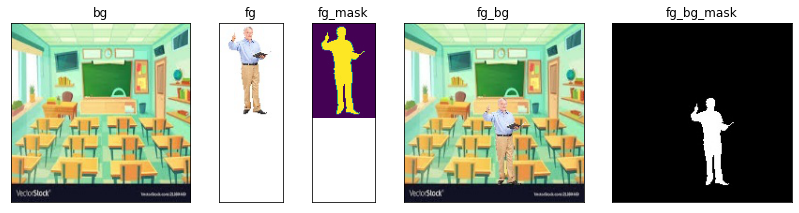

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

image_data = [bg_img, fg_img, fg_mask_img, fg_bg_img, fg_bg_mask_img]
image_label = ["bg", "fg", "fg_mask", "fg_bg", "fg_bg_mask"]

fig = plt.figure(figsize=(14., 14.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 5),  # creates 2x2 grid of axes
                 axes_pad=0.4,  # pad between axes in inch.
                 )

for ax, im, label in zip(grid, image_data, image_label):
    # Iterating over the grid returns the Axes.
    #ax.imshow(im[...,::-1])
    ax.imshow(im)
    ax.set_title(label)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

### Sample work: Visualize all kinds of images

In [0]:
#ROOT_IMAGE_DIR = "D:/my_learning/TSAI/EVA4/assignments/session14_15/cur_work/dataset_exp"

bg_file = os.path.join(ROOT_IMAGE_DIR,"bg_images/img_001.jpg")
fg_file = os.path.join(ROOT_IMAGE_DIR,"fg_images/img_002.jpg")
mask_file = os.path.join(ROOT_IMAGE_DIR,"fg_mask_images/img_002.jpg")

bg_img = cv2.imread(bg_file, cv2.IMREAD_COLOR)
fg_img = cv2.imread(fg_file, cv2.IMREAD_COLOR)
fg_mask = cv2.imread(mask_file, cv2.IMREAD_COLOR)

fg_img_flip = cv2.flip(fg_img, 1)
fg_mask_flip = cv2.flip(fg_mask, 1)

fg_bg, fg_bg_mask = create_fg_bg_img(bg_img, fg_img, fg_mask)
fg_bg_flip, fg_bg_mask_flip = create_fg_bg_img(bg_img, fg_img_flip, fg_mask_flip)

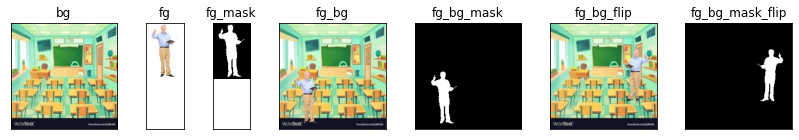

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

image_data = [bg_img, fg_img, fg_mask, fg_bg, fg_bg_mask, fg_bg_flip, fg_bg_mask_flip]
image_label = ["bg", "fg", "fg_mask", "fg_bg", "fg_bg_mask", "fg_bg_flip", "fg_bg_mask_flip"]

fig = plt.figure(figsize=(14., 14.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 7),  # creates 2x2 grid of axes
                 axes_pad=0.4,  # pad between axes in inch.
                 )

for ax, im, label in zip(grid, image_data, image_label):
    # Iterating over the grid returns the Axes.
    ax.imshow(im[...,::-1])
    ax.set_title(label)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

###  Sample work: visualize internal image data while preparing fg_bg creation for debugging and understanding

This show step by step procedure for preparing fg_bg and its equivalent mask. sample os particular bg, fg, fg_mask image is considered for understanding

In [0]:
bg_file = os.path.join(ROOT_IMAGE_DIR,"bg_images/img_002.jpg")
fg_file = os.path.join(ROOT_IMAGE_DIR,"fg_images/img_002.jpg")
mask_file = os.path.join(ROOT_IMAGE_DIR,"fg_mask_images/img_002.jpg")

(192, 192, 3)


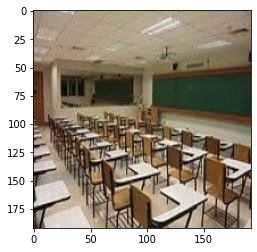

In [24]:
bg_img = cv2.imread(bg_file, cv2.IMREAD_COLOR)
print(bg_img.shape)
plt.imshow(bg_img[...,::-1])

(102, 68, 3)


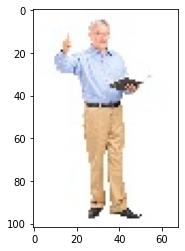

In [25]:
fg_img = cv2.imread(fg_file, cv2.IMREAD_COLOR)
h, w = fg_img.shape[:2]
print(fg_img.shape)
plt.imshow(fg_img[...,::-1])

(102, 68, 3)


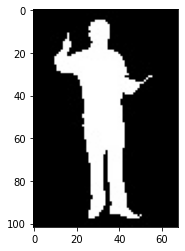

In [26]:
fg_mask = cv2.imread(mask_file, cv2.IMREAD_COLOR)
print(fg_mask.shape)
plt.imshow(fg_mask[...,::-1])

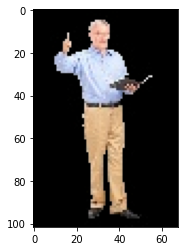

In [27]:
fg_img_with_mask = cv2.bitwise_and(fg_img, fg_mask)
plt.imshow(fg_img_with_mask[...,::-1])

In [0]:
# choose random locations for masking
h_start = np.random.randint(0,bg_img.shape[0]-h)
w_start= np.random.randint(0,bg_img.shape[1]-w)

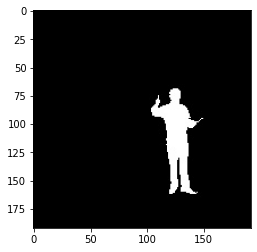

In [29]:
# create mask for fg and bg overlay images 
fg_bg_mask = np.zeros(bg_img.shape, bg_img.dtype)
fg_bg_mask.fill(0)
fg_bg_mask[h_start:h_start+h, w_start:w_start+w] = fg_mask[:,:]
plt.imshow(fg_bg_mask[...,::-1])

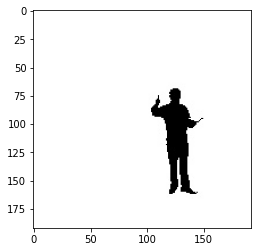

In [30]:
fg_bg_mask_inv = cv2.bitwise_not(fg_bg_mask)
plt.imshow(fg_bg_mask_inv[...,::-1])

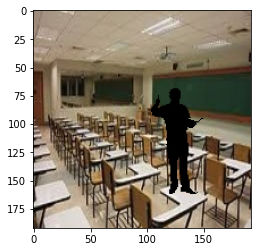

In [31]:
bg_overlay = cv2.bitwise_and(bg_img, fg_bg_mask_inv)
plt.imshow(bg_overlay[...,::-1])

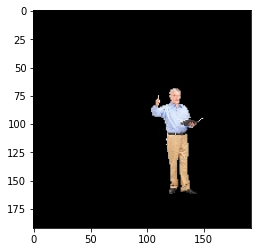

In [32]:
fg_overlay = np.zeros(bg_img.shape, bg_img.dtype)
fg_overlay.fill(0)
fg_overlay[h_start:h_start+h, w_start:w_start+w] = fg_img_with_mask[:,:]
plt.imshow(fg_overlay[...,::-1])

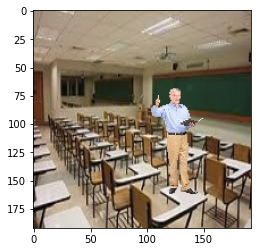

In [33]:
fg_bg = cv2.add(bg_overlay, fg_overlay) 
plt.imshow(fg_bg[...,::-1])